## Chargement des données

In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
import numpy as np
import sys
import os
import pandas as pd
import ast
from dotenv import load_dotenv
import seaborn as sns
load_dotenv()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from api.services.database_helper import get_all_vectors_from_db, connect_to_db

In [2]:
conn = connect_to_db()
all_data = get_all_vectors_from_db(conn)
print(type(all_data))

<class 'list'>


In [3]:
df = pd.read_csv("embedding.csv")
df.head()

,id,vector
0,52ef707a572da4e903000556,"[0.18677342,0.2172054,0.3031756,0.016607251,-0..."
1,52ef6f044ea6bfe52e00099c,"[-0.21022785,0.07977808,0.061076757,-0.1016258..."
2,52ef704d122bb64c4f00093a,"[0.23940459,0.22484551,0.2711723,0.03518518,-0..."
3,52efa289572da4e9030005ae,"[0.14386003,0.17271268,0.16389565,0.07044793,-..."
4,52ef71cd5c4baf9e610008a7,"[0.20130442,0.15990795,0.2808601,0.15049519,-0..."


In [4]:
from pymongo import MongoClient


# Connexion à MongoDB
mongo_url = os.getenv("MONGO_URL")  # Assurez-vous que la variable d'environnement est définie
client = MongoClient(mongo_url)
db = client["G1"]
collection = db["threads"]

# Récupérer tous les _id de la collection threads
valid_ids = set(doc["_id"] for doc in collection.find({}, {"_id": 1}))

# Garder uniquement les données dont l'id est dans valid_ids
# filtered_data = [item for item in all_data if item[0] in valid_ids]
filtered_data = df[df["id"].isin(valid_ids)]

print(type(filtered_data))
print(len(filtered_data))  # Vérifier combien de données ont été filtrées

<class 'pandas.core.frame.DataFrame'>
37218


In [5]:
# print(all_data[0])
# df = pd.DataFrame(all_data, columns=['id', 'vector'])
df['vector'] = df['vector'].apply(lambda x: ast.literal_eval(x))
print(df.head())

                         id                                             vector
0  52ef707a572da4e903000556  [0.18677342, 0.2172054, 0.3031756, 0.016607251...
1  52ef6f044ea6bfe52e00099c  [-0.21022785, 0.07977808, 0.061076757, -0.1016...
2  52ef704d122bb64c4f00093a  [0.23940459, 0.22484551, 0.2711723, 0.03518518...
3  52efa289572da4e9030005ae  [0.14386003, 0.17271268, 0.16389565, 0.0704479...
4  52ef71cd5c4baf9e610008a7  [0.20130442, 0.15990795, 0.2808601, 0.15049519...


## Application du k-means

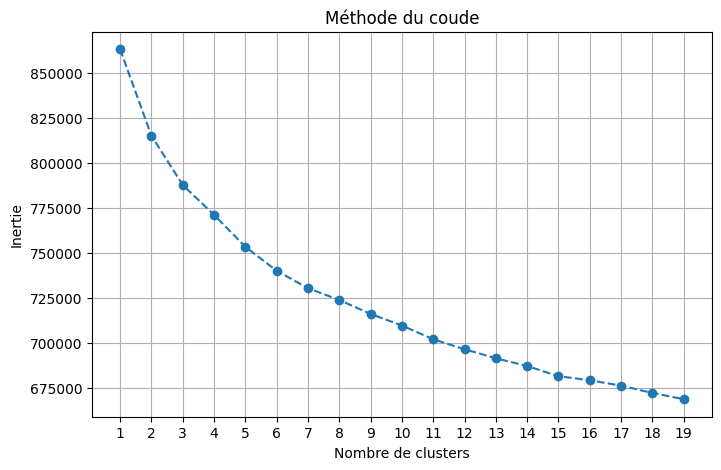

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculer l'inertie pour différents nombres de clusters
inertias = []
range_clusters = range(1, 20)

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(list(df['vector']))
    inertias.append(kmeans.inertia_)

# Tracer la courbe de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertias, marker='o', linestyle='--')
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.xticks(range_clusters)
plt.grid()
plt.show()

In [7]:
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(list(df['vector']))
df['cluster'] = kmeans.labels_
df.head()

,id,vector,cluster
0,52ef707a572da4e903000556,"[0.18677342, 0.2172054, 0.3031756, 0.016607251...",12
1,52ef6f044ea6bfe52e00099c,"[-0.21022785, 0.07977808, 0.061076757, -0.1016...",9
2,52ef704d122bb64c4f00093a,"[0.23940459, 0.22484551, 0.2711723, 0.03518518...",12
3,52efa289572da4e9030005ae,"[0.14386003, 0.17271268, 0.16389565, 0.0704479...",12
4,52ef71cd5c4baf9e610008a7,"[0.20130442, 0.15990795, 0.2808601, 0.15049519...",12


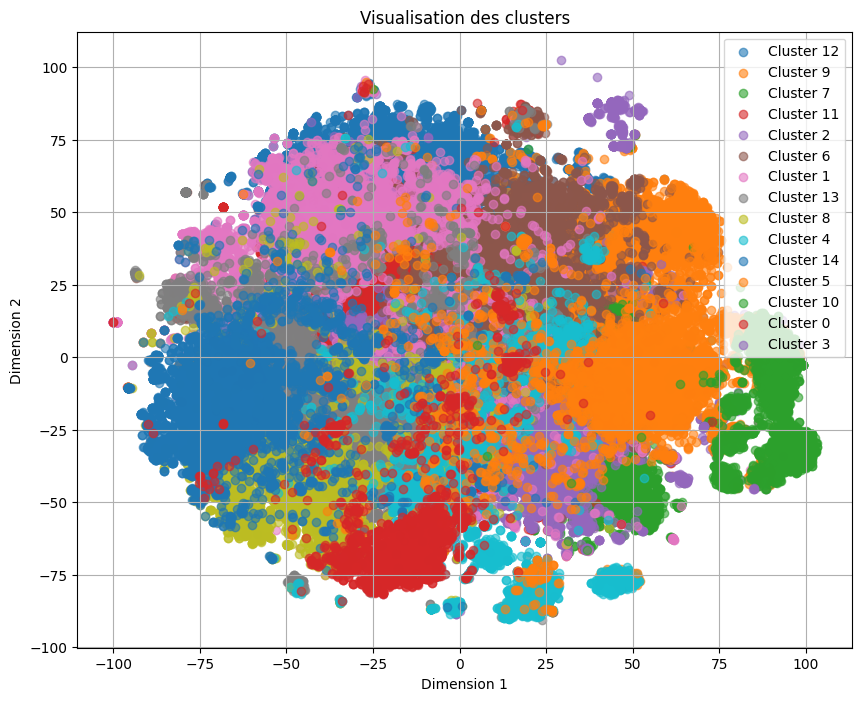

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(np.array(list(df['vector'])))

# Ajouter les coordonnées réduites au DataFrame
df['x'] = reduced_vectors[:, 0]
df['y'] = reduced_vectors[:, 1]

# Visualisation
plt.figure(figsize=(10, 8))
for cluster_id in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("Visualisation des clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid()
plt.show()

## Récupérer les autres données de chaque messages

In [9]:
mongo_url = os.getenv("MONGO_URL")
client = MongoClient(mongo_url)
db = client["G1"]
collection = db["threads"]

collection.find()
# mettre dans un dictionnaire pour un accès plus rapide
complete_data = {}
all_category = {}
for doc in collection.find():
    complete_data[doc["_id"]] = doc["content"]["title"] if "content" in doc and "title" in doc["content"] else ""
    all_category[doc["_id"]] = doc["content"]["courseware_title"] if "content" in doc and "courseware_title" in doc["content"] else ""
    
df["title"] = ""
df["category"] = ""
for index, row in df.iterrows():
    try:
        id = row["id"]
        df.at[index, "title"] = complete_data[id]
        df.at[index, "category"] = all_category[id]
    except KeyError:
        df.at[index, "title"] = ""
        df.at[index, "category"] = ""
    
df.head()

,id,vector,cluster,x,y,title,category
0,52ef707a572da4e903000556,"[0.18677342, 0.2172054, 0.3031756, 0.016607251...",12,-4.095016,78.425400,,
1,52ef6f044ea6bfe52e00099c,"[-0.21022785, 0.07977808, 0.061076757, -0.1016...",9,38.079674,21.108013,Presentation: Ulrich R.,Entre nous / Presentez-vous
2,52ef704d122bb64c4f00093a,"[0.23940459, 0.22484551, 0.2711723, 0.03518518...",12,-4.092165,78.434326,,
3,52efa289572da4e9030005ae,"[0.14386003, 0.17271268, 0.16389565, 0.0704479...",12,-2.556641,74.893921,,
4,52ef71cd5c4baf9e610008a7,"[0.20130442, 0.15990795, 0.2808601, 0.15049519...",12,-2.794511,74.392509,,


In [10]:
df["category"].value_counts()
df_thread = df[df["category"] != ""]
df_thread = df[df["title"] != ""]

88


C:\Users\melos\AppData\Local\Temp\ipykernel_7936\2502545317.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_thread['category'] = df_thread['category'].apply(lambda x: x if x in common_categories else "Autres")


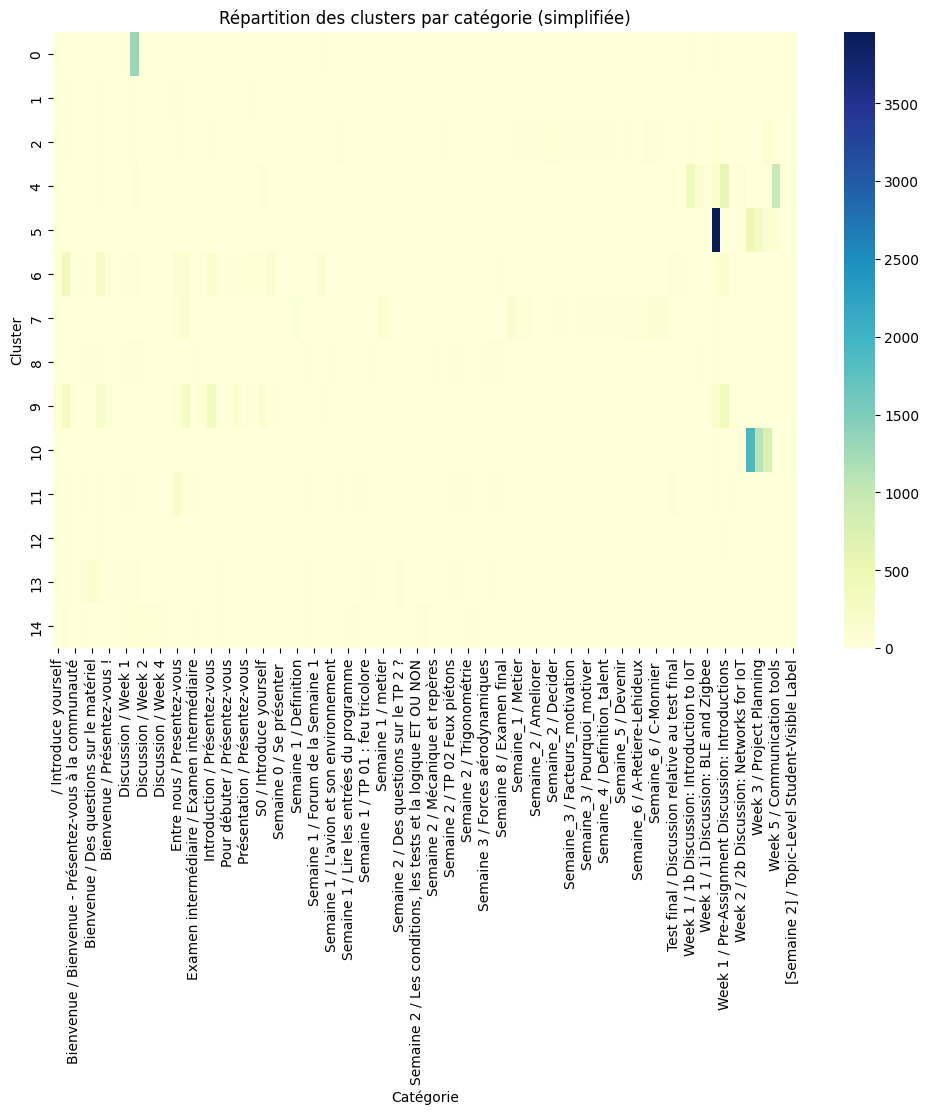

In [11]:
# Regrouper les catégories rares
threshold = 50  # Seuil minimal d'occurrences pour conserver une catégorie
category_counts = df_thread['category'].value_counts()
common_categories = category_counts[category_counts >= threshold].index
print(len(common_categories))
# Remplacer les catégories rares par "Autres"
df_thread['category'] = df_thread['category'].apply(lambda x: x if x in common_categories else "Autres")
df_thread = df_thread[df_thread['category'] != "Autres"]
df_thread = df_thread[df_thread['category'] != ""]
df_thread = df_thread[df_thread['category'] != " "]

# Recréer le tableau croisé dynamique
cluster_category_distribution = pd.crosstab(df_thread['cluster'], df_thread['category'])

# Tracer une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_category_distribution, annot=False, fmt="d", cmap="YlGnBu")
plt.title("Répartition des clusters par catégorie (simplifiée)")
plt.xlabel("Catégorie")
plt.ylabel("Cluster")
plt.show()

## Nouvel essai de clustering avec les catégories et un autre modèle

In [13]:

df_category = df[["id", "vector", "category"]]
df_category = df_category[df_category["category"] != ""]
df_category.head()

,id,vector,category
1,52ef6f044ea6bfe52e00099c,"[-0.21022785, 0.07977808, 0.061076757, -0.1016...",Entre nous / Presentez-vous
6,52ef6f324ea6bfe52e00099f,"[0.18884778, 0.18823367, -0.15745841, -0.24394...",Semaine_1 / Metier
8,52ef6fe24b4451380f0008d4,"[0.21302685, -0.063770786, 0.037784353, 0.1273...",Semaine_1 / Generale_semaine_1
14,52ef70f6572da4e903000558,"[0.24275315, 0.0535007, -0.13643476, -0.060126...",Semaine_1 / Metier
17,52ef711091f923142b000919,"[0.034110304, 0.0053122756, -0.088552624, 0.00...",Entre nous / Presentez-vous


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.preprocessing import StandardScaler

# One-Hot Encoding du champ category
encoder = OneHotEncoder(sparse_output=False)
category_encoded = encoder.fit_transform(df_category[['category']])

# Combiner les vecteurs et les catégories encodées
X = np.hstack((np.array(list(df_category['vector'])), category_encoded))
X = StandardScaler().fit_transform(X)
# Appliquer DBSCAN
dbscan = DBSCAN(eps=10, min_samples=5, metric='euclidean')
df_category['cluster'] = dbscan.fit_predict(X)

In [ ]:
df_category['cluster'].value_counts()

cluster
-1     31019
 12      244
 11      173
 3        43
 2        42
 4        41
 1        38
 5        16
 6        12
 10       10
 19        9
 9         8
 20        7
 16        7
 7         7
 0         6
 13        6
 8         5
 21        5
 17        5
 15        5
 14        5
 18        5
Name: count, dtype: int64

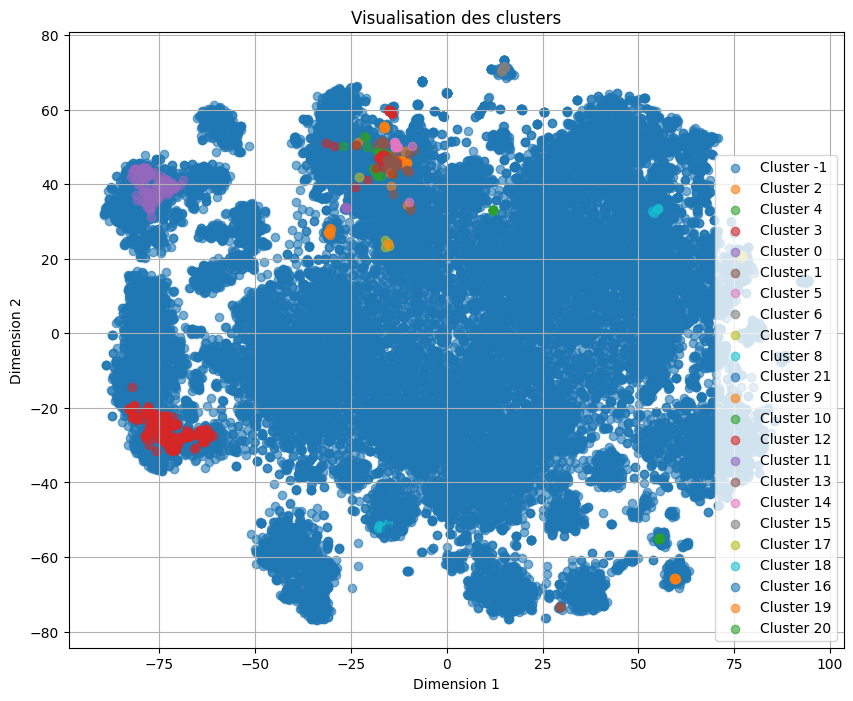

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(np.array(list(df_category['vector'])))

# Ajouter les coordonnées réduites au DataFrame
df_category['x'] = reduced_vectors[:, 0]
df_category['y'] = reduced_vectors[:, 1]

# Visualisation
plt.figure(figsize=(10, 8))
for cluster_id in df_category['cluster'].unique():
    cluster_data = df_category[df_category['cluster'] == cluster_id]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("Visualisation des clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid()
plt.show()

## Avec Kmeans + category

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler

# One-Hot Encoding du champ category
encoder = OneHotEncoder(sparse_output=False)
category_encoded = encoder.fit_transform(df_category[['category']])

# Combiner les vecteurs et les catégories encodées
X = np.hstack((np.array(list(df_category['vector'])), category_encoded))
X = StandardScaler().fit_transform(X)

# Appliquer KMeans
n_clusters = 20  # Choisissez un nombre de clusters approprié
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_category['cluster'] = kmeans.fit_predict(X)

# Afficher les clusters
print(df_category['cluster'].value_counts())

cluster
13    5080
15    5056
0     4496
17    3435
12    2327
6     2201
4     1926
9     1890
14    1571
5     1078
16    1018
10     991
11     303
3      118
8       89
1       63
7       36
2       20
19      19
18       1
Name: count, dtype: int64


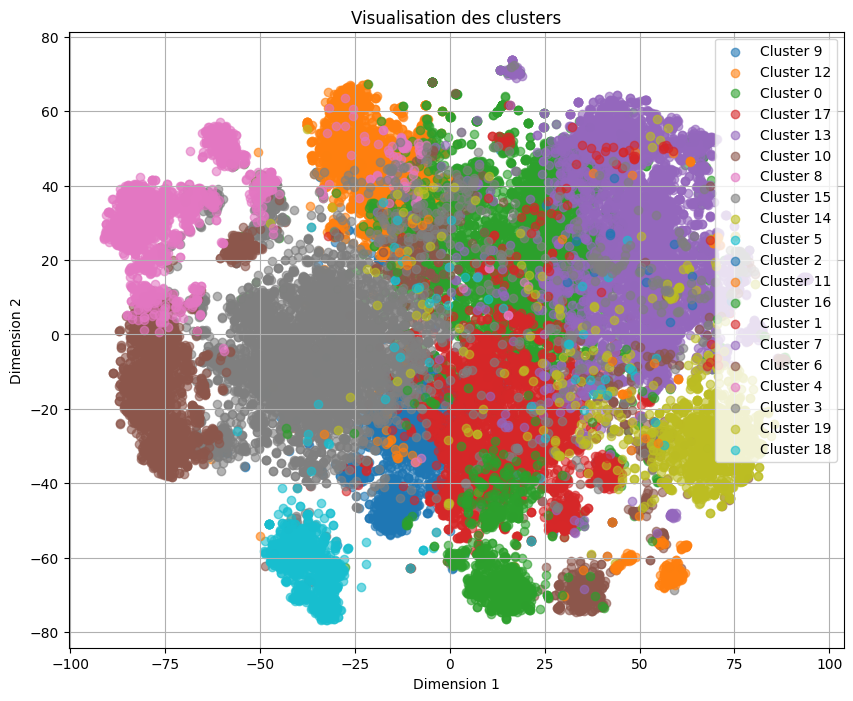

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(np.array(list(df_category['vector'])))

# Ajouter les coordonnées réduites au DataFrame
df_category['x'] = reduced_vectors[:, 0]
df_category['y'] = reduced_vectors[:, 1]

# Visualisation
plt.figure(figsize=(10, 8))
for cluster_id in df_category['cluster'].unique():
    cluster_data = df_category[df_category['cluster'] == cluster_id]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("Visualisation des clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid()
plt.show()

87


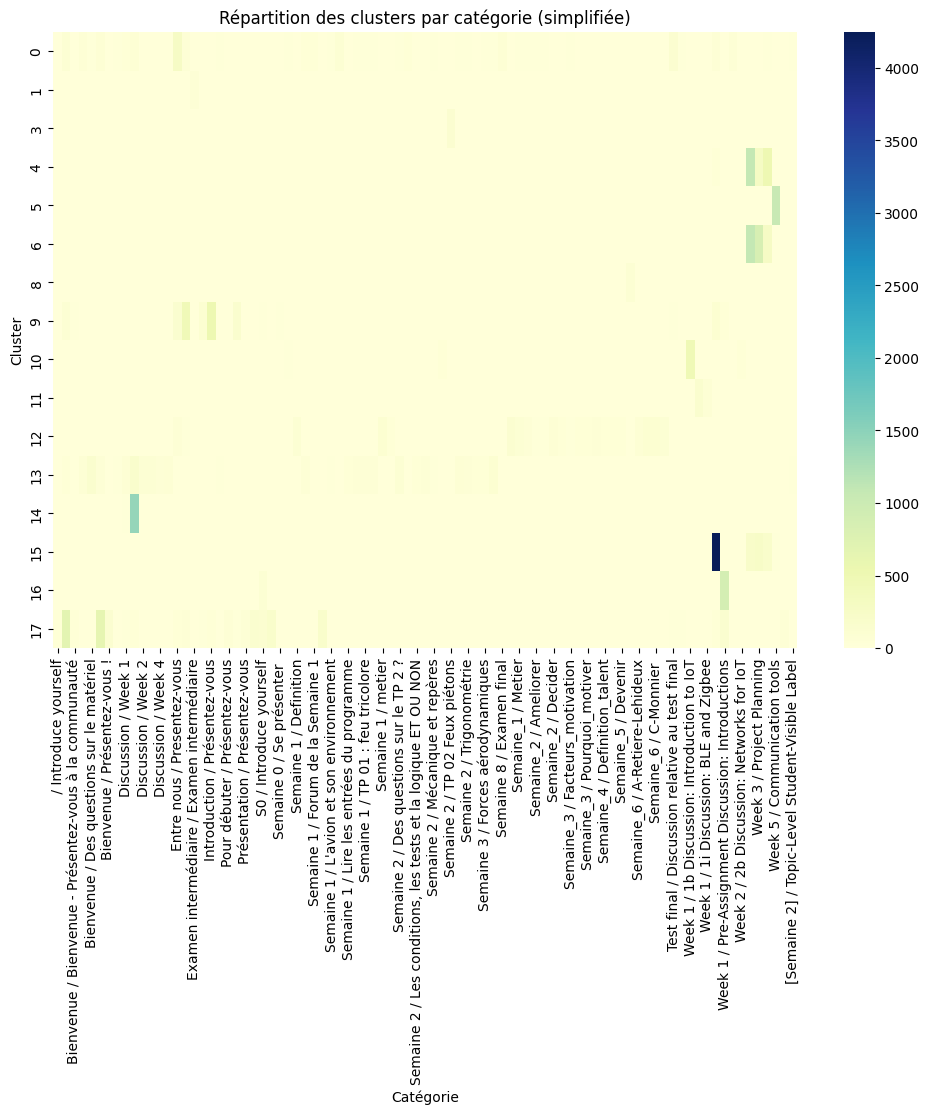

In [16]:
df_category_test = df_category.copy()
# Regrouper les catégories rares
threshold = 50  # Seuil minimal d'occurrences pour conserver une catégorie
category_counts = df_category_test['category'].value_counts()
common_categories = category_counts[category_counts >= threshold].index
print(len(common_categories))
# Remplacer les catégories rares par "Autres"
df_category_test['category'] = df_category_test['category'].apply(lambda x: x if x in common_categories else "Autres")
df_category_test = df_category_test[df_category_test['category'] != "Autres"]
df_category_test = df_category_test[df_category_test['category'] != ""]
df_category_test = df_category_test[df_category_test['category'] != " "]

# Recréer le tableau croisé dynamique
cluster_category_distribution = pd.crosstab(df_category_test['cluster'], df_category_test['category'])

# Tracer une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_category_distribution, annot=False, fmt="d", cmap="YlGnBu")
plt.title("Répartition des clusters par catégorie (simplifiée)")
plt.xlabel("Catégorie")
plt.ylabel("Cluster")
plt.show()

## Essai d'optimisation du nombre de cluster pour Kmeans

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_scores = []
range_clusters = range(2, 40)  # Tester différents nombres de clusters

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(list(df['vector']))
    silhouette_scores.append(silhouette_score(list(df['vector']), labels))

# Tracer le score silhouette
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, silhouette_scores, marker='o', linestyle='--')
plt.title("Silhouette Score pour différents nombres de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

KeyboardInterrupt: 

## Test de Top2vec

In [20]:
mongo_url = os.getenv("MONGO_URL")
client = MongoClient(mongo_url)
db = client["G1"]
collection = db["threads"]

documents = []
for doc in collection.find():
    body = doc["content"]["body"] if "content" in doc and "body" in doc["content"] else ""
    if body:
        documents.append(body)

In [21]:
from top2vec import Top2Vec

model = Top2Vec(documents, speed="fast-learn", workers=8, embedding_model="distiluse-base-multilingual-cased")

topic_words, word_scores, topic_nums = model.get_topics()
for i, words in enumerate(topic_words):
    print(f"Topic {i}: {', '.join(words)}")

2025-05-14 15:49:55,082 - top2vec - INFO - Pre-processing documents for training
c:\Users\melos\Documents\formation greta\projet_mooc_test\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-05-14 15:50:08,527 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2025-05-14 15:50:10,855 - top2vec - INFO - Creating joint document/word embedding


KeyboardInterrupt: 

In [15]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=5)
for doc in documents:
    print(doc)

Bonjour. je tiens a remercier très sincèrement toute l'équipe de m’avoir permis de faire un plus a mes connaissances. Et j'avoue que j'ai passé des moments forts dans cet apprentissage. Maintenant que je viens de finir l'examen final j'aimerai avoir une idée de la continuité de cette formation. 
Par ailleurs j'avais une petite inquiétude: Au moment du remplissage des formulaire d'inscription vous ne m'avez demandez aucun document attestant mon niveau est-ce que cela ne compromet pas l'authenticité et le caractère sérieux de l'attestation. 
En fait, parlant de continuité, je fait allusion a un niveau supérieur de la formation en management. Si non pourriez-vous, avec ma licence en gestion, me suggérer une formation compatible avec mon profil?
Et enfin j'aimerai savoir comment ce passera la remise de l'attestation. Si la boite postale est nécessaire ya t-il possibilité de modifier la boite postale initialement inscrit?

Encore merci à vous pour tout 
Bonjour à tous.

Je viens de terminer

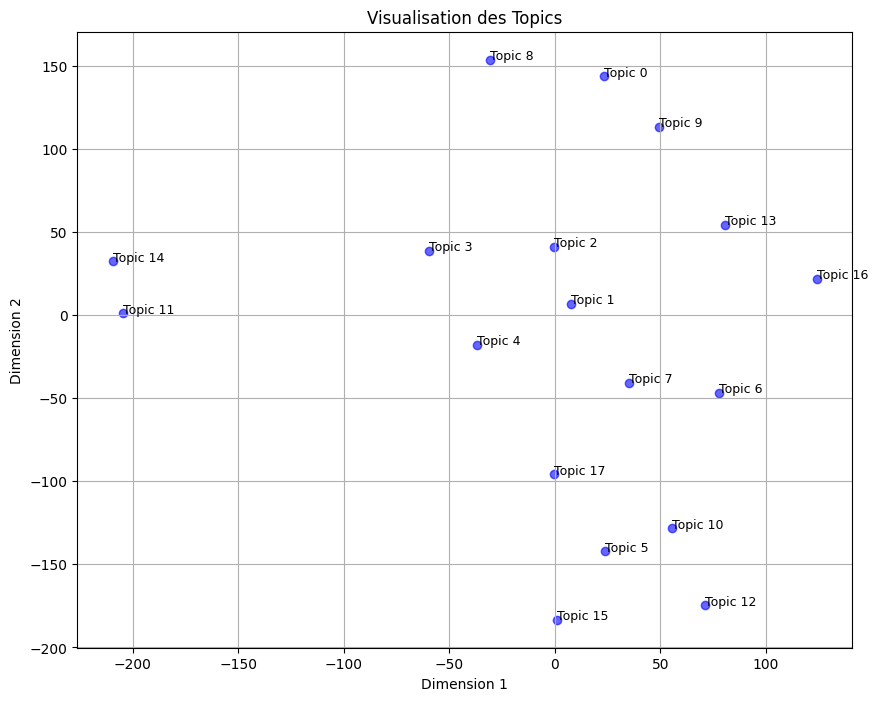

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Obtenir les vecteurs des topics
topic_vectors = model.topic_vectors

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_topics = tsne.fit_transform(topic_vectors)

# Tracer les topics
plt.figure(figsize=(10, 8))
plt.scatter(reduced_topics[:, 0], reduced_topics[:, 1], c='blue', alpha=0.6)
for i, (x, y) in enumerate(reduced_topics):
    plt.text(x, y, f"Topic {i}", fontsize=9)
plt.title("Visualisation des Topics")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()
plt.show()

## Test Bertopic

In [5]:
from bertopic import BERTopic
# from huggingface_hub import DocumentQuestionAnsweringInputData
from pymongo import MongoClient
mongo_url = os.getenv("MONGO_URL")
client = MongoClient(mongo_url)
db = client["G1"]
collection = db["threads"]

documents = []
for doc in collection.find({"content.course_id": "CNAM/01002/Trimestre_1_2014"}):
    body = doc["content"]["body"] if "content" in doc and "body" in doc["content"] else ""
    if body:
        documents.append(body)


model = BERTopic(verbose=True) # BERTopic(nr_topics=5)
model.fit(documents)
topics, probabilities = model.transform(documents)

model.get_topic_freq().head(10)

2025-05-14 16:55:09,824 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 80/80 [00:59<00:00,  1.35it/s]
2025-05-14 16:56:11,353 - BERTopic - Embedding - Completed ✓
2025-05-14 16:56:11,354 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-14 16:56:26,051 - BERTopic - Dimensionality - Completed ✓
2025-05-14 16:56:26,059 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-14 16:56:26,204 - BERTopic - Cluster - Completed ✓
2025-05-14 16:56:26,232 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-14 16:56:26,491 - BERTopic - Representation - Completed ✓
Batches: 100%|██████████| 80/80 [00:55<00:00,  1.44it/s]
2025-05-14 16:57:22,264 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-14 16:57:22,264 - BERTopic - Dimensionality - Completed ✓
2025-05-14 16:57:22,264 - BERTopic - Clustering - Approximating new points with `hdbscan_mod

,Topic,Count
1,-1,1078
5,0,225
0,1,182
9,2,179
2,3,154
6,4,98
10,5,51
18,6,47
17,7,42
16,8,39


In [6]:
model.get_topic(2)

[('dcision', 0.05520722578093143),
 ('de', 0.029333159923381754),
 ('dcisions', 0.026778075041165632),
 ('prendre', 0.024705869562788377),
 ('la', 0.023968278778073514),
 ('une', 0.020928382807094435),
 ('le', 0.020918125474117245),
 ('choix', 0.02074841845001132),
 ('prise', 0.019577236182662456),
 ('en', 0.019472239298492604)]

In [7]:
model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'leader | leadership | un | manager | le', 225],
                                   [1, 'mooc | je | ce | suis | de', 182],
                                   [2, 'dcision | de | dcisions | prendre | la', 179],
                                   [3, 'manager | de | le | mtier | doit', 154],
                                   [4, 'talent | talents | gestion | des | la', 98],
                                   [5, 'rponse | rponses | la | question | pas', 51],
                                   [6, 'gonon | il | un | leader | manager', 47],
                                   [7, 'motivation | la | concept | de | thorie', 42],
                                   [8, 'pas | cest | bon | ne | je', 39],
                                   [9, 'manager | q2 | q3 | q1 | q4', 38],
                                   [10, 'talents | gestion | manager | talent | du', 35],
                                   [11, 'motivation | de | collaborateurs | motivations | motiver', 34],
                                   [12, 'monnier | ses | des | le | et', 30],
                                   [13, 'hangout | vous | google | vidos | questions', 30],
                                   [14, 'dcisions | dcider | appliquer | manager | de', 29],
                                   [15, 'cavarretta | de | dcision | les | le', 29],
                                   [16, 'test | final | jai | je | tests', 26],
                                   [17, 'russite | bonjour | attestations | lattestation | merci', 25],
                                   [18, 'tous | je | mooc | suis | ccile', 25],
                                   [19, 'de | et | dans | en | plus', 20],
                                   [20, 'jacinto | leader | le | manager | les', 16],
                                   [21, 'les | il | direction | de | pour', 15],
                                   [22, 'retirelehideux | manager | la | le | de', 15],
                                   [23, 'chef | dorchestre | sil | manager | lquipe', 14],
                                   [24, 'vroom | facteurs | thorie | la | motivation', 13],
                                   [25, 'presentation | prsentation | lequipe | merci | ete', 12],
                                   [26, 'bonjour | attestation | attestations | savoir | quand', 12],
                                   [27, 'bonjour | 360 | ai | chaine | je', 11],
                                   [28, 'femme | femmes | enrichissants | hommes | tmoignages', 10]],
                                  dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': {'bdata': '4QC2ALMAmgBiADMALwAqACcAJgAjACIAHgAeAB0AHQAaABkAGQAUABAADwAPAA4ADQAMAAwACwAKAA==',
                                  'dtype': 'i2'},
                         'sizemode': 'area',
                         'sizeref': 0.140625,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('Jausv1tqJ0GRv4m/NTabvyVNxL+ohT' ... 'W/jsucQFtXxUFf/r5BW64wQdDO4L8='),
                    'dtype': 'f4'},
              'xaxis': 'x',
              'y': {'bdata': ('asjtwHkxycAx4gXB8/vewMIPwMCrU8' ... 'DAl96PQQQ86cAcJmBBzITBwPV8+MA='),
                    'dtype': 'f4'},
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': -2.109264224767685,
                                'y': 5.556008458137512,
                                'yshift': 10},
                               {'showarrow': False,
                                'text'

In [8]:
model.visualize_barchart()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02885038819078308, 0.031050756956235725,
                    0.03194068644477529, 0.03312508575521689, 0.05761281914475153],
              'xaxis': 'x',
              'y': [le  , manager  , un  , leadership  , leader  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.027681657936463825, 0.03067146025821891,
                    0.030766802431895907, 0.046710131075621296,
                    0.05919713314852326],
              'xaxis': 'x2',
              'y': [de  , suis  , ce  , je  , mooc  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.023968278778073514, 0.024705869562788377,
                    0.026778075041165632, 0.029333159923381754,
                    0.05520722578093143],
              'xaxis': 'x3',
              'y': [la  , prendre  , dcisions  , de  , dcision  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.022455691336463964, 0.023212069834719077,
                    0.023334898497596308, 0.026976329699167613,
                    0.034817177379744796],
              'xaxis': 'x4',
              'y': [doit  , mtier  , le  , de  , manager  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02838613236740673, 0.03209257039960564, 0.03736211567708014,
                    0.05568161238883127, 0.0735273392333422],
              'xaxis': 'x5',
              'y': [la  , des  , gestion  , talents  , talent  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02712990836671658, 0.028842419076956945,
                    0.030945473806222545, 0.0480608608535788, 0.04984392034937905],
              'xaxis': 'x6',
              'y': [pas  , question  , la  , rponses  , rponse  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.0262213429339431, 0.026531178706883544,
                    0.026667325844224907, 0.02843060472737704, 0.06566387659708484],
              'xaxis': 'x7',
              'y': [manager  , leader  , un  , il  , gonon  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.026630306202269385, 0.031753739777305556,
                    0.03524521776769824, 0.0477772094951968, 0.0854018933289492],
              'xaxis': 'x8',
              'y': [thorie  , de  , concept  , la  , motivation  ],
              'yaxis': 'y8'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                              

In [9]:
model.visualize_heatmap()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_leader_leadership_un, 1_mooc_je_ce, 2_dcision_de_dcisions,
                    3_manager_de_le, 4_talent_talents_gestion, 5_rponse_rponses_la,
                    6_gonon_il_un, 7_motivation_la_concept, 8_pas_cest_bon,
                    9_manager_q2_q3, 10_talents_gestion_manager,
                    11_motivation_de_collaborat..., 12_monnier_ses_des,
                    13_hangout_vous_google, 14_dcisions_dcider_appliquer,
                    15_cavarretta_de_dcision, 16_test_final_jai,
                    17_russite_bonjour_attestat..., 18_tous_je_mooc, 19_de_et_dans,
                    20_jacinto_leader_le, 21_les_il_direction,
                    22_retirelehideux_manager_la, 23_chef_dorchestre_sil,
                    24_vroom_facteurs_thorie, 25_presentation_prsentation...,
                    26_bonjour_attestation_atte..., 27_bonjour_360_ai,
                    28_femme_femmes_enrichissants],
              'xaxis': 'x',
              'y': [0_leader_leadership_un, 1_mooc_je_ce, 2_dcision_de_dcisions,
                    3_manager_de_le, 4_talent_talents_gestion, 5_rponse_rponses_la,
                    6_gonon_il_un, 7_motivation_la_concept, 8_pas_cest_bon,
                    9_manager_q2_q3, 10_talents_gestion_manager,
                    11_motivation_de_collaborat..., 12_monnier_ses_des,
                    13_hangout_vous_google, 14_dcisions_dcider_appliquer,
                    15_cavarretta_de_dcision, 16_test_final_jai,
                    17_russite_bonjour_attestat..., 18_tous_je_mooc, 19_de_et_dans,
                    20_jacinto_leader_le, 21_les_il_direction,
                    22_retirelehideux_manager_la, 23_chef_dorchestre_sil,
                    24_vroom_facteurs_thorie, 25_presentation_prsentation...,
                    26_bonjour_attestation_atte..., 27_bonjour_360_ai,
                    28_femme_femmes_enrichissants],
              'yaxis': 'y',
              'z': {'bdata': ('AwCAPwg1NT+3NDs/kZJmP07FNz8WHh' ... '9HOww/dmsePzmeDz9oOx0/AgCAPw=='),
                    'dtype': 'f4',
                    'shape': '29, 29'}}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Similarity Score'}},
                             'colorscale': [[0.0, 'rgb(247,252,240)'], [0.125,
                                            'rgb(224,243,219)'], [0.25,
                                            'rgb(204,235,197)'], [0.375,
                                            'rgb(168,221,181)'], [0.5,
                                            'rgb(123,204,196)'], [0.625,
                                            'rgb(78,179,211)'], [0.75,
                                            'rgb(43,140,190)'], [0.875,
                                            'rgb(8,104,172)'], [1.0,
                                            'rgb(8,64,129)']]},
               'height': 800,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'title': {'text': 'Trend'}},
               'margin': {'t': 60},
               'showlegend': True,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Similarity Matrix</b>',
                         'x': 0.55,
                         'xanchor': 'center',
                         'y': 0.95,
                         'yanchor': 'top'},
               'width': 800,
               'xaxis': {'anchor': 'y', 'constrain': 'domain', 'domain': [0.0, 1.0], 'scaleanchor': 'y'},
               'yaxis': {'anchor': 'x', 'autorange': 'reversed', 'constrain': 'domain', 'domain': [0.0, 1.0]}}
})